# Install ASE

with modifications for symmetrized surfaces

In [1]:
import subprocess
import sys
try:
    sys.path.insert(0,'/data/git/ase/')
except FileNotFoundError as E:
    pass
try:
    import ase
except ModuleNotFoundError as E:
    subprocess.check_call([sys.executable, '-m','pip','install','git+https://gitlab.com/mdforti/ase.git'])
    import ase

# Load Machinery for google drive


In [2]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as E:
    pass
    
if os.path.exists('/content/drive'):
  pathtofiles='/content/drive/Shareddrives/Tenacidad_Zr-ZrO2/'
else:
  pathtofiles=os.getcwd()
if pathtofiles is not os.getcwd():
  os.chdir(pathtofiles)

# load ASE 

In [3]:

from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.build import surface, make_supercell
from ase.build.surfaces_with_termination import surfaces_with_termination, atom_index_in_top, atom_index_in_bottom
from ase.geometry import get_layers
from ase.build import bulk, hcp10m10, hcp0001
from ase.build import stack
from ase.io import write
from ase.io.vasp import write_vasp
from importlib.machinery import  SourceFileLoader
from ase import Atoms
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
import numpy as np

In [4]:
from ase.build.surfaces_with_termination import (atom_index_in_bottom, atom_index_in_top)

In [5]:
zro2 = read_vasp('Structure/POSCAR')

In [6]:
def plotviews(atoms_object,
              rotation1='-90x',
              rotation2='-90x, 45y',
              rotation3='0x'):
  fig = plt.figure()
  ax1 = fig.add_axes((0.1,0.1, 0.3,0.8))
  ax2 = fig.add_axes((0.3,0.1, 0.3,0.8))
  ax3 = fig.add_axes((0.6,0.1, 0.3,0.8))
  plot_atoms(atoms_object,rotation=rotation1, ax=ax1)
  plot_atoms(atoms_object,rotation=rotation2, ax=ax2)
  plot_atoms(atoms_object,rotation=rotation3,ax=ax3)
  return ax1, ax2, ax3

In [7]:
def remove_bottom_atom(theatoms):
    atoms = theatoms.copy()
    layers, hs = get_layers(atoms,(0,0,1))
    atoms_in_bottom = atom_index_in_bottom(layers)
    atoms.pop(atoms_in_bottom[-1])
    return atoms

# Objetivo

lo primero que quiero hacer es reconstruir la interfaz de paula:

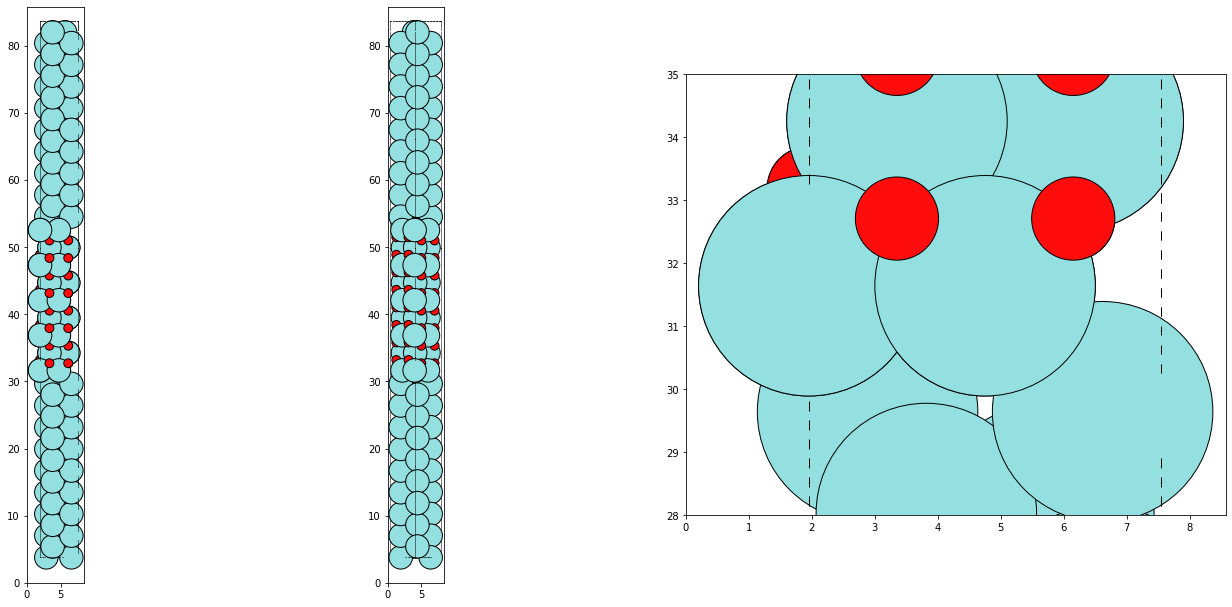

In [8]:
intf=read_vasp('Interfaces/POSCAR_primero.vasp')

ax1, ax2, ax3 = plotviews(intf, rotation3='-90x')
ax3.set_ylim([28,35])
fig = plt.gcf()

- observamos que con esos parámetros de red la ZrO<sub>2</sub> está muy comprimida (casi el 30%, hay dos celdas en el slab de óxido)
- observamos que la terminación de la zr debe ser O(valle) , mientras que la que está ahí calculada es Zr.
- a demás hay demasiados átomos!

respecto de esa última observación, tomamos en VESTA la siguiente estructura:

In [9]:
intf_red = read_vasp('Interfaces/POSCAR_reducido.vasp')

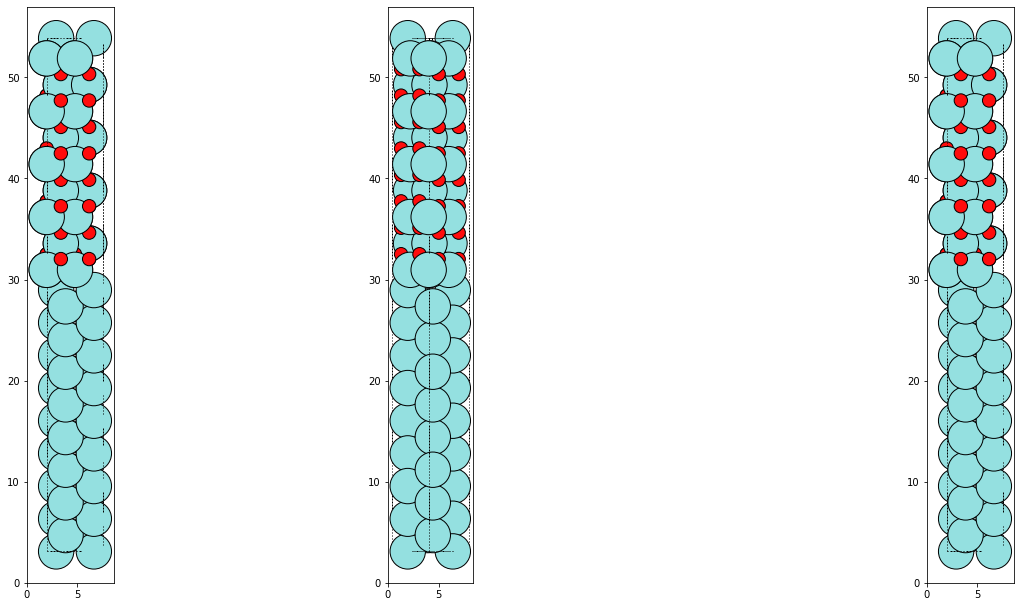

In [10]:
ax1, ax2, ax3 = plotviews(intf_red, rotation3='-90x')

# Superficies

In [73]:
get_adsite = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().get_adsite
make_adstruc = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().make_adstruc

## ZrO2

tratamos de hacer las superficie que a paula le dió mas estable

primero genero la superficie de ZrO<sub>2</sub>

para tener la superficie mas estable y simétrica, hay que sacar algunos átmos:
- los oxígenos de la ceresta
- los zr de la tapa de abajo

# Superficies con terminacion con ASE

In [12]:
ZrO2001Oterm = surfaces_with_termination(zro2, [0,0,1],layers=4, vacuum=15., termination='O',verbose=True, symmetric=True)
[write_vasp(f'ZrO2001_1x1_{i}.vasp', thisone, sort=True, direct=True) for i, thisone in enumerate(ZrO2001Oterm)]

([4], ['Zr']) ([20], ['O'])
([3], ['O']) ([18], ['O'])
([5], ['Zr']) ([21], ['O'])
([2], ['O']) ([19], ['O'])


[None, None, None, None]

In [13]:
ZrO2001Zrterm = surfaces_with_termination(zro2, [0,0,1], 5, vacuum=10., termination='Zr')

In [14]:
# [ plotviews(this) for this in ZrO2001Oterm]

In [15]:
ZrO2001_2x2 = [make_supercell(ZrO2001Oterm[i],[[2,0,0],[0,2,0],[0,0,1]],tol=1e-10, wrap=True) for i in range(len(ZrO2001Oterm))]
translate = [this.translate([this[0].x]) for this in ZrO2001_2x2]
[this.write(f'ZrO2001_2x2_{i}.vasp',sort=True, direct=True, format='vasp') for i,this in enumerate(ZrO2001_2x2)]

[None, None, None, None]

la que corresponde con el modelo de Paula es la última, pero para que quede igual hay que hacerle una trasación todavía:

[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

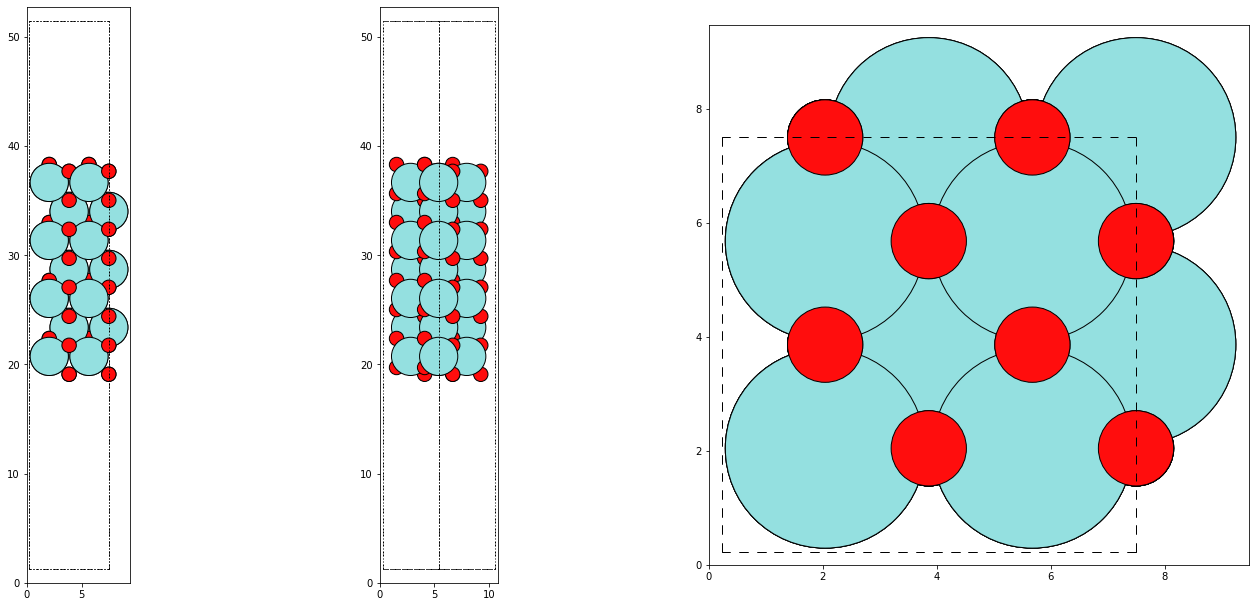

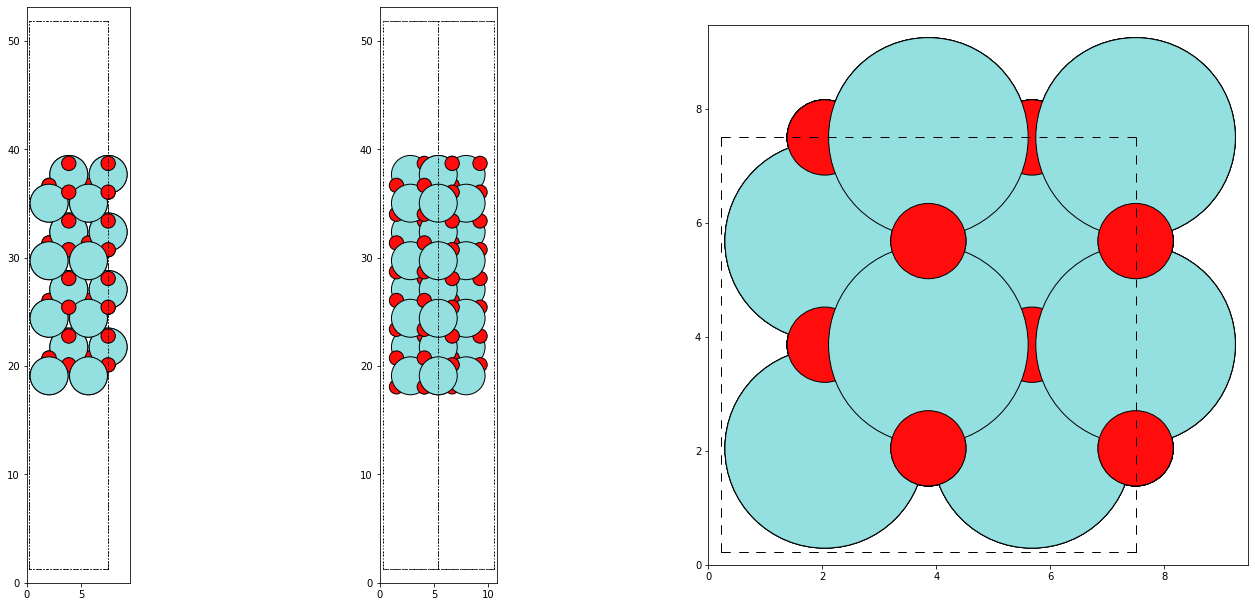

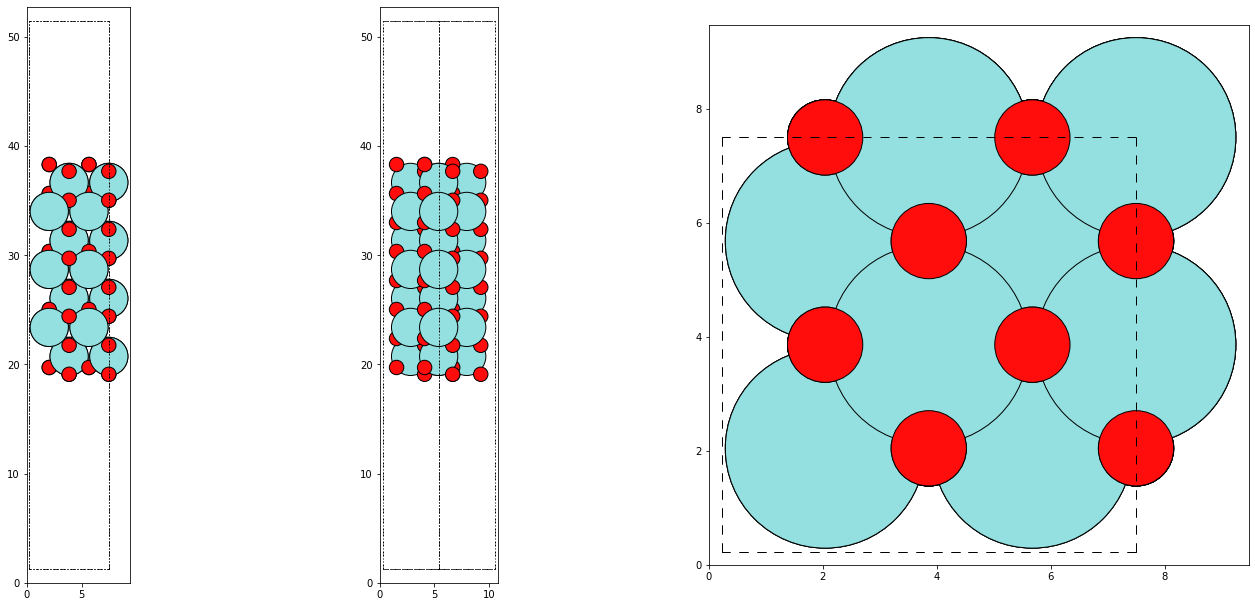

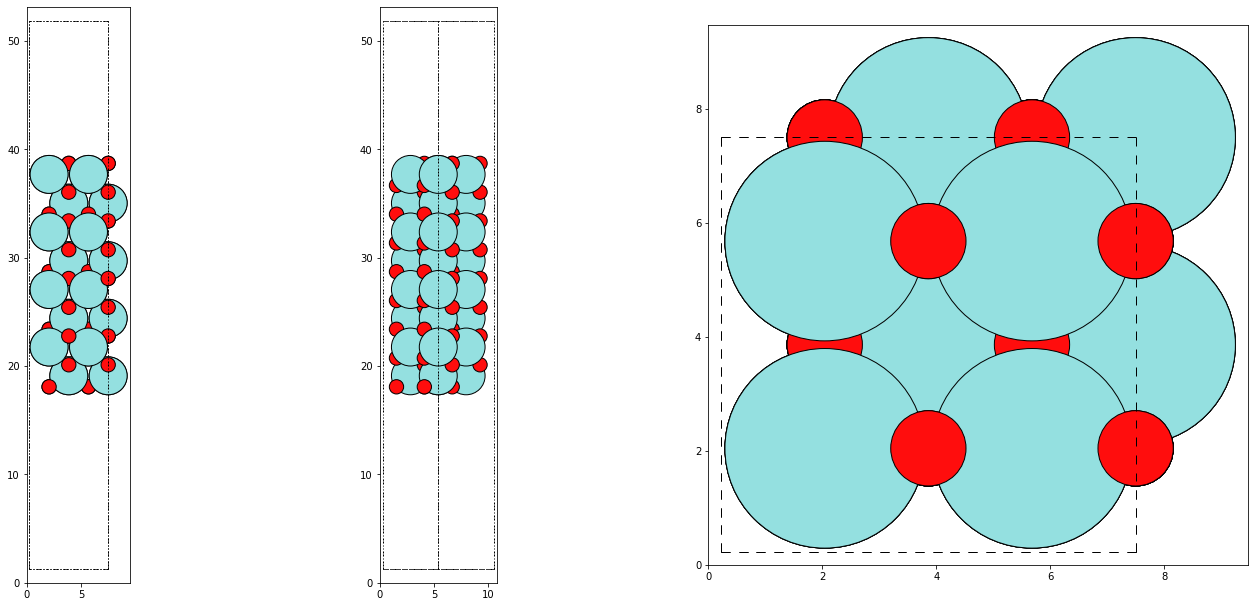

In [16]:
[ plotviews(this) for this in ZrO2001_2x2]

In [17]:
get_adsite = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().get_adsite

thesites  = [get_adsite(theintf,site='top', face='bottom') for theintf in ZrO2001_2x2]

In [18]:
for i, theslab in enumerate(ZrO2001_2x2):
    site = 'top'
    adposition = theslab.info['adatom']['bottom'][site][0]
    adatom = Atoms('H',positions=[adposition-[0,0,2]])
    adstruc = theslab.copy()
    adstruc.extend(adatom)
    adstruc.write(f'ZrO20001_ad{site}_{i}.vasp',format='vasp', sort=True, wrap=True)
    

In [19]:
ZrO2001_2x2[1].info

{'adatom': {'bottom': {'top': array([[ 1.8170995 ,  3.63419899, 16.8170995 ],
          [ 1.8170995 ,  7.26839798, 16.8170995 ],
          [ 5.45129849,  3.63419899, 16.8170995 ],
          [ 5.45129849,  7.26839798, 16.8170995 ]])}}}

## circonium

In [20]:
zrhcpa = 3.2313 # Zr.cell[0][0]
zrhcpc = 5.1479 # Zr.cell[-1][-1]

zrhcp = bulk('Zr',crystalstructure='hcp',a=zrhcpa, c = zrhcpc,orthorhombic=True)

(<Axes:>, <Axes:>, <Axes:>)

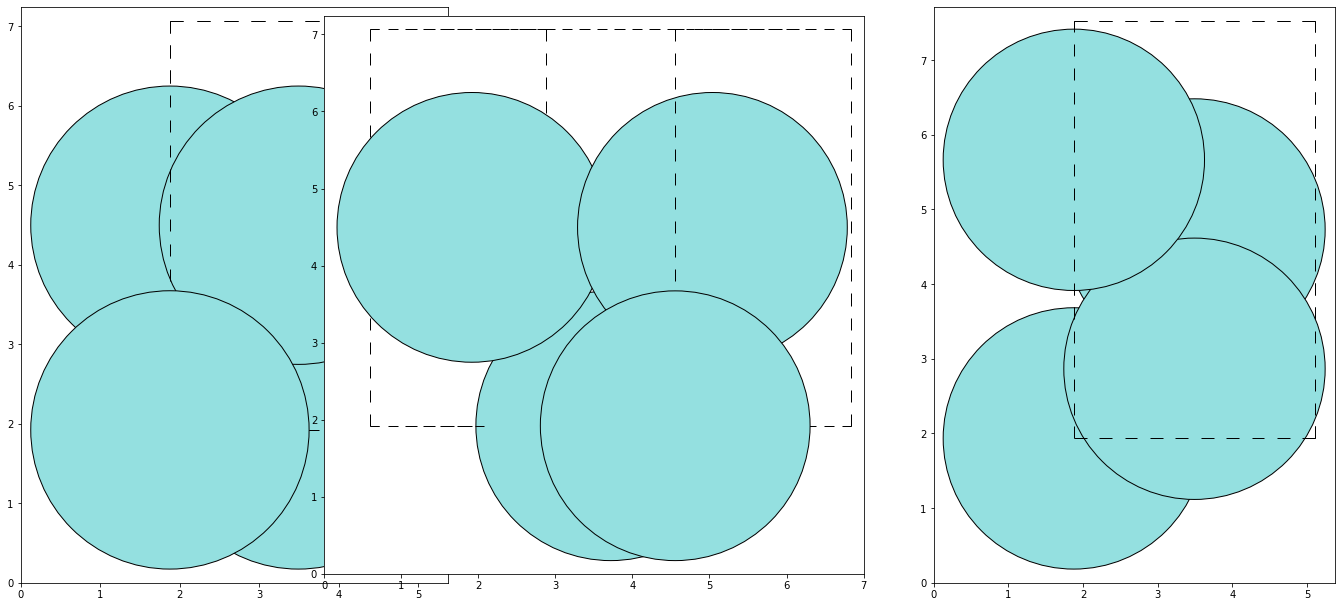

In [21]:
plotviews(zrhcp)

for hexagonal lattices, the equivalence to make the correct surfaces is :
- (0 0 0 1): (0 0 1)
- (1 0 -1 0): (1 0 0)
- (1 1 -2 0): (1 1 0)

now i want to remove the bottom layer, so bottoma nd top have same symmetry

## Zr0001

In [34]:
Zr0001 = surfaces_with_termination(zrhcp, (0,0,1), 5, vacuum=10, termination='Zr')[0]
Zr0001 = remove_bottom_atom(Zr0001)
Zr0001 = remove_bottom_atom(Zr0001)
#Zr0001.pop(atoms_in_bottom[-1])

In [35]:
get_adsite = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().get_adsite

In [36]:
adsites_zr0001 = get_adsite(Zr0001, site='top')

In [39]:
Zr0001_adtop = make_adstruc(Zr0001,'Zr0001_adtop')

(<Axes:>, <Axes:>, <Axes:>)

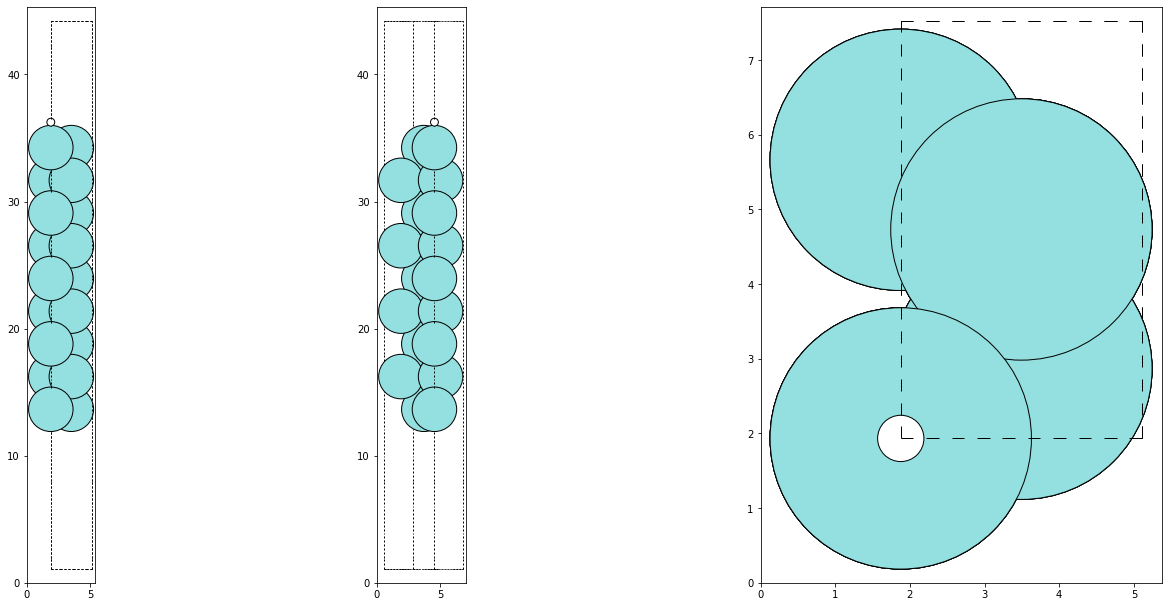

In [40]:
plotviews(Zr0001_adtop)

In [38]:
Zr0001_2x2=make_supercell(Zr0001, [[2,0,0],[0,1,0],[0,0,1]],)
Zr0001_2x2.write('Zr0001_2x2.vasp',sort=True,wrap=True, direct=True,vasp5=True)

(<Axes:>, <Axes:>, <Axes:>)

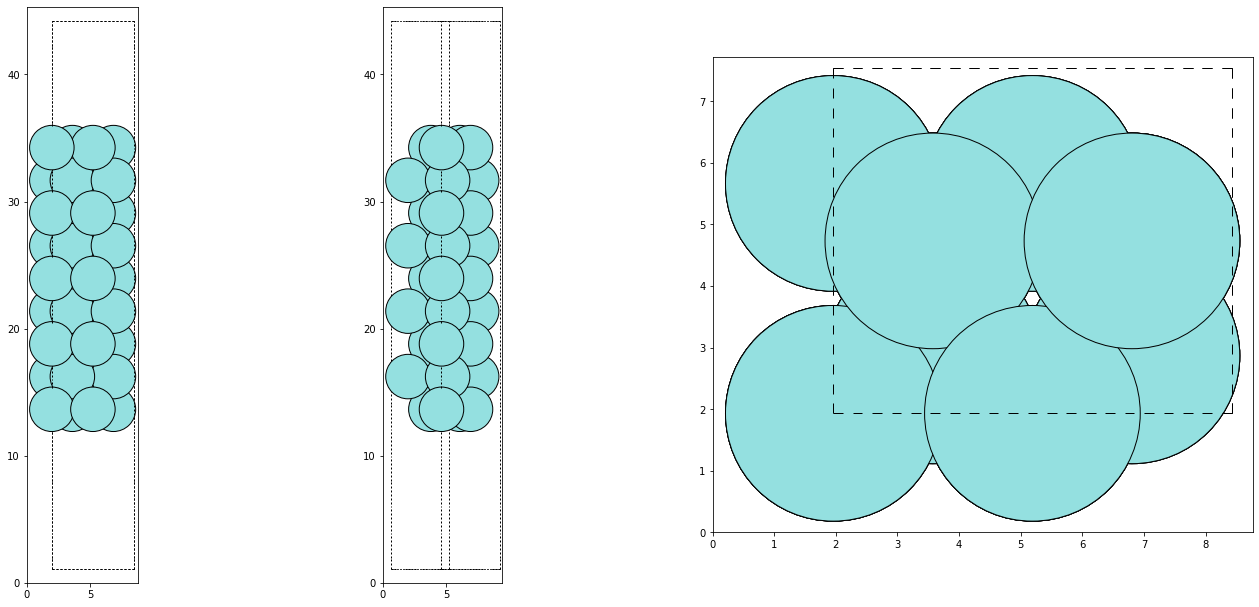

In [24]:
plotviews(Zr0001_2x2)

In [94]:
get_adsite = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().get_adsite

In [42]:
adsites_zr0001 = get_adsite(Zr0001, site='top')

In [43]:
adsites_zr0001 = get_adsite(Zr0001, site='hollow')

In [44]:
Zr0001_ontop = make_adstruc(Zr0001,'Zr0001_top',thesite='top' )

In [45]:
Zr0001_onhollow = make_adstruc(Zr0001,'Zr0001_hollow',thesite='hollow' )

(<Axes:>, <Axes:>, <Axes:>)

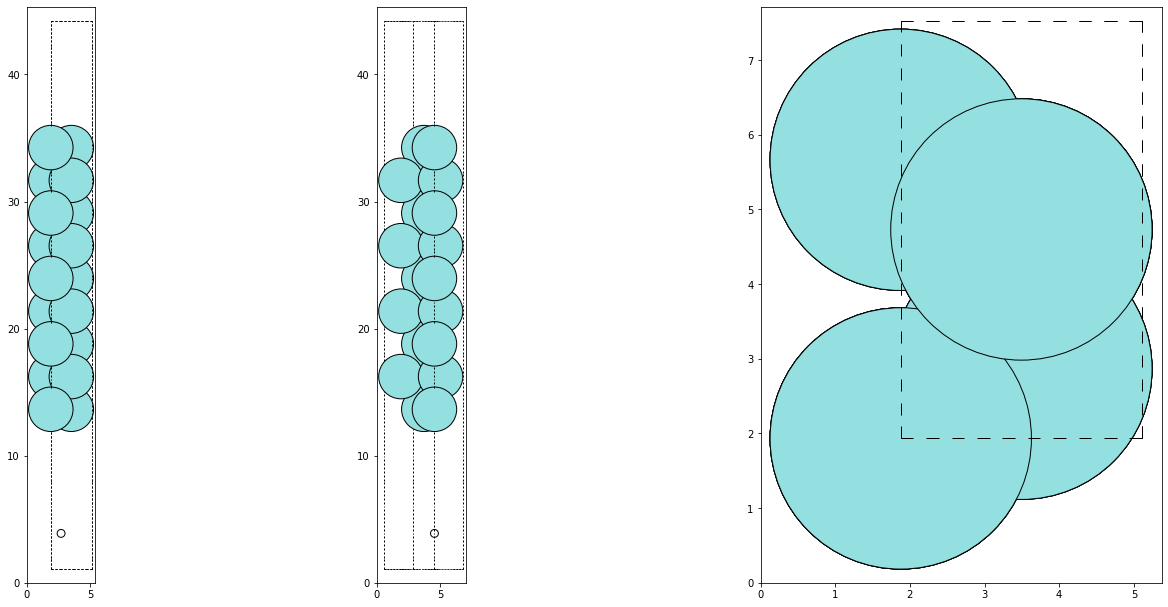

In [47]:
plotviews(Zr0001_onhollow)

## 10-10

In [154]:
make_adstruc = SourceFileLoader('make_adstruc',
                               'Tools.py').load_module().make_adstruc

In [155]:
Zr0101=surfaces_with_termination(zrhcp,(1,0,0),8, vacuum=10)[0]
Zr0101 = remove_bottom_atom(Zr0101)
Zr0101 = remove_bottom_atom(Zr0101)

In [156]:
Zr0101_2x2 = make_supercell(Zr0101, [[1,0,0],[0,1,0],[0,0,1]], wrap=True)

In [157]:
adsites_Zr0101 = get_adsite(Zr0101_2x2, site='top')
adsites_Zr0101 = get_adsite(Zr0101_2x2, site='hollow')

In [158]:
Zr0101_ontop = make_adstruc(Zr0101_2x2,'Zr0101_top',thesite='top')
Zr0101_onhollow = make_adstruc(
    Zr0101_2x2,
    'Zr0101_hollow',
    thesite='hollow')

(<Axes:>, <Axes:>, <Axes:>)

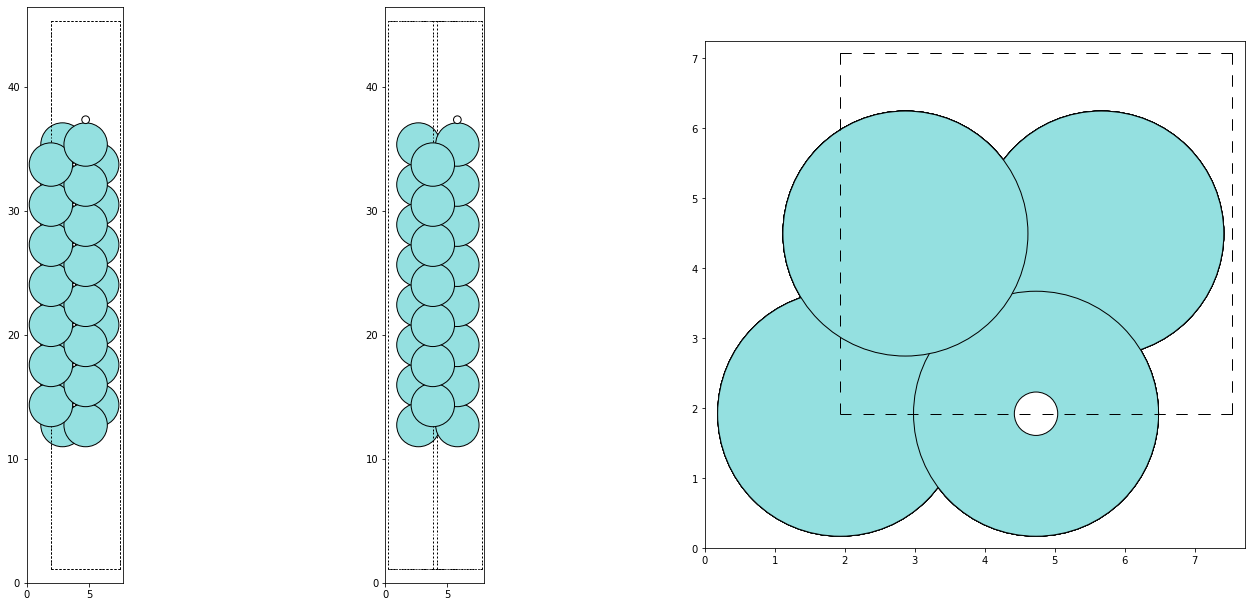

In [159]:
plotviews(Zr0101_ontop)

## zr1120

In [160]:
Zr1120 = surfaces_with_termination(zrhcp,[1,1,0], 9, vacuum=10, symmetric=True)[0]
Zr1120 = remove_bottom_atom(Zr1120)
Zr1120 = remove_bottom_atom(Zr1120)


([2, 3], ['Zr', 'Zr']) ([32, 33], ['Zr', 'Zr'])
([0, 1], ['Zr', 'Zr']) ([34, 35], ['Zr', 'Zr'])
([2, 3], ['Zr', 'Zr']) ([32, 33], ['Zr', 'Zr'])


In [161]:
adsites_Zr1120 = get_adsite(Zr1120, site='top')
adsites_Zr1120 = get_adsite(Zr1120, site='hollow')

In [162]:
Zr1120_ontop = make_adstruc(Zr1120,'Zr1120_top',thesite='top')
Zr1120_onhollow = make_adstruc(Zr1120,'Zr1120_hollow',thesite='hollow')

(<Axes:>, <Axes:>, <Axes:>)

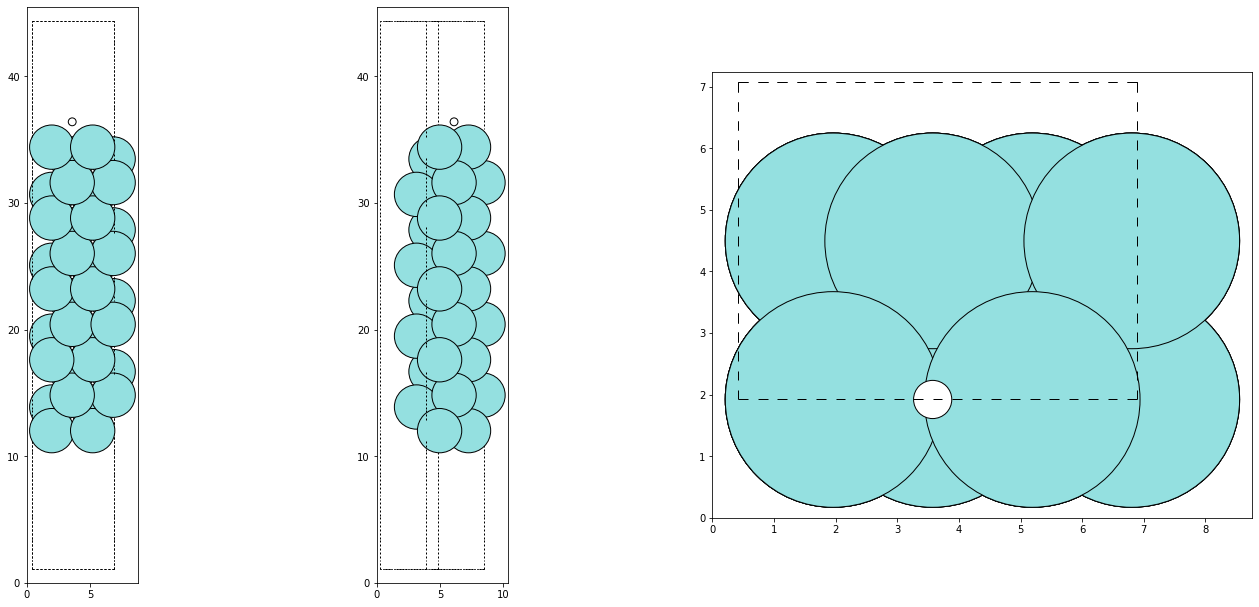

In [164]:
plotviews(Zr1120_onhollow)

In [165]:
Zr1120.get_global_number_of_atoms()

34

# Interfaces

Ok here is a tricky one. if you dont use a non linked cell in the `cell` option, this option is actually a pointer to the input var. this means that if you use atoms.cell and atoms is a slab to stack, this will totally mess the input atom and the output too. This also happens you you use no cell as imput because it assigns a pointer internally

In [189]:
stack = SourceFileLoader(
    'stack',
    'Tools.py').load_module().stack

In [190]:
thestack, thestacked = stack(ZrO2001_2x2[1], Zr1120, 'hollow','top',2, cell = ZrO2001_2x2[1].cell.copy())

20.613835994823027


(<Axes:>, <Axes:>, <Axes:>)

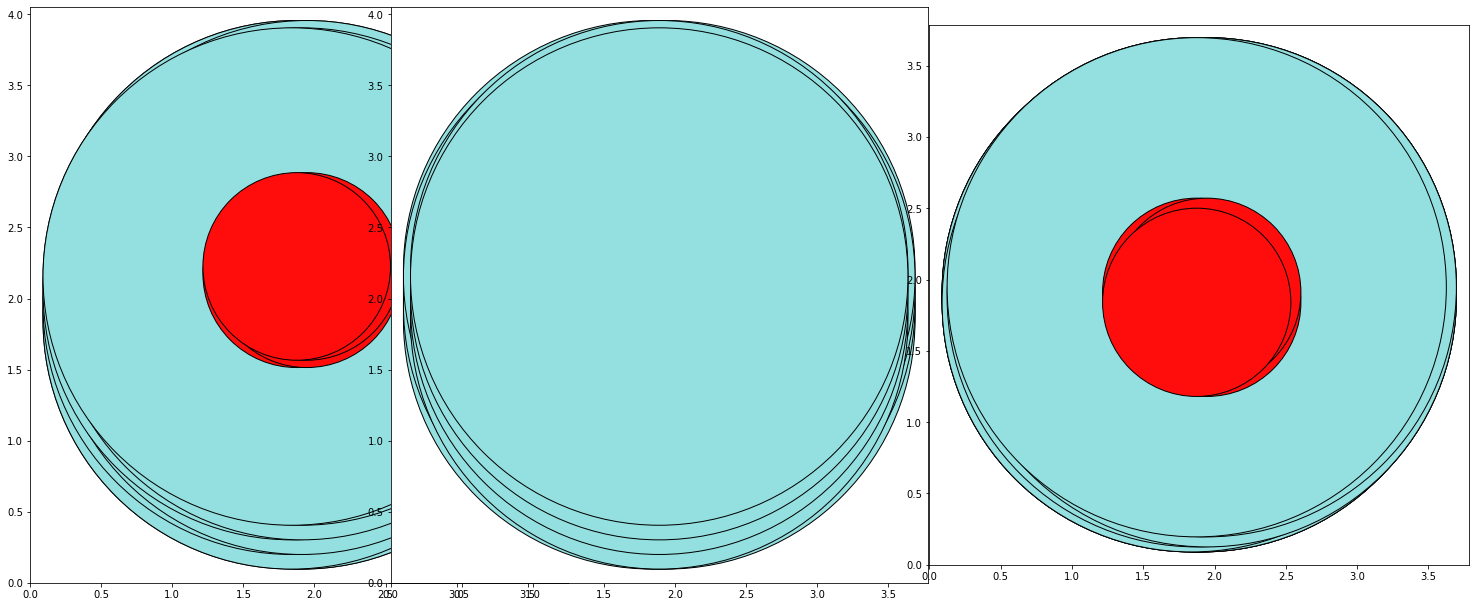

In [192]:
plotviews(thestack)

In [193]:
thestack.positions

array([[0.03518301, 0.        , 0.0907363 ],
       [0.03518301, 0.        , 0.03933753],
       [0.        , 0.03518301, 0.05139876],
       [0.        , 0.03518301, 0.        ],
       [0.03518301, 0.03518301, 0.07106753],
       [0.        , 0.        , 0.01966877],
       [0.03518301, 0.        , 0.19353382],
       [0.03518301, 0.        , 0.14213506],
       [0.        , 0.03518301, 0.15419629],
       [0.        , 0.03518301, 0.10279753],
       [0.03518301, 0.03518301, 0.17386506],
       [0.        , 0.        , 0.12246629],
       [0.03518301, 0.        , 0.29633135],
       [0.03518301, 0.        , 0.24493258],
       [0.        , 0.03518301, 0.25699381],
       [0.        , 0.03518301, 0.20559505],
       [0.03518301, 0.03518301, 0.27666258],
       [0.        , 0.        , 0.22526382],
       [0.03518301, 0.        , 0.39912887],
       [0.03518301, 0.        , 0.34773011],
       [0.        , 0.03518301, 0.35979134],
       [0.        , 0.03518301, 0.30839258],
       [0.

In [178]:
thestack

Atoms(symbols='O64Zr66', pbc=[True, True, False], cell=[7.268397980708341, 7.268397980708341, 43.00093909281229])

In [169]:
ZrO2001_2x2[1].cell

Cell([7.268397980708341, 7.268397980708341, 50.61383599482303])

In [36]:
Zr0101.__dict__['info']

{}

In [169]:
intfLayer = [stack(Zr0101_2x2.copy(), I.copy(), cell=I.cell.copy(), axis=2, distance=2, maxstrain=4, reorder=True) for I in ZrO2001_2x2]
saveintfs = [a.write( f'intf_zr0101_zro2_{i}.vasp', format='vasp',sort=True,  direct=True,  wrap=True) for i, a in enumerate(intfLayer)]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 243
         Function evaluations: 398
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 237
         Function evaluations: 392
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 244
         Function evaluations: 393
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 251
         Function evaluations: 405


[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

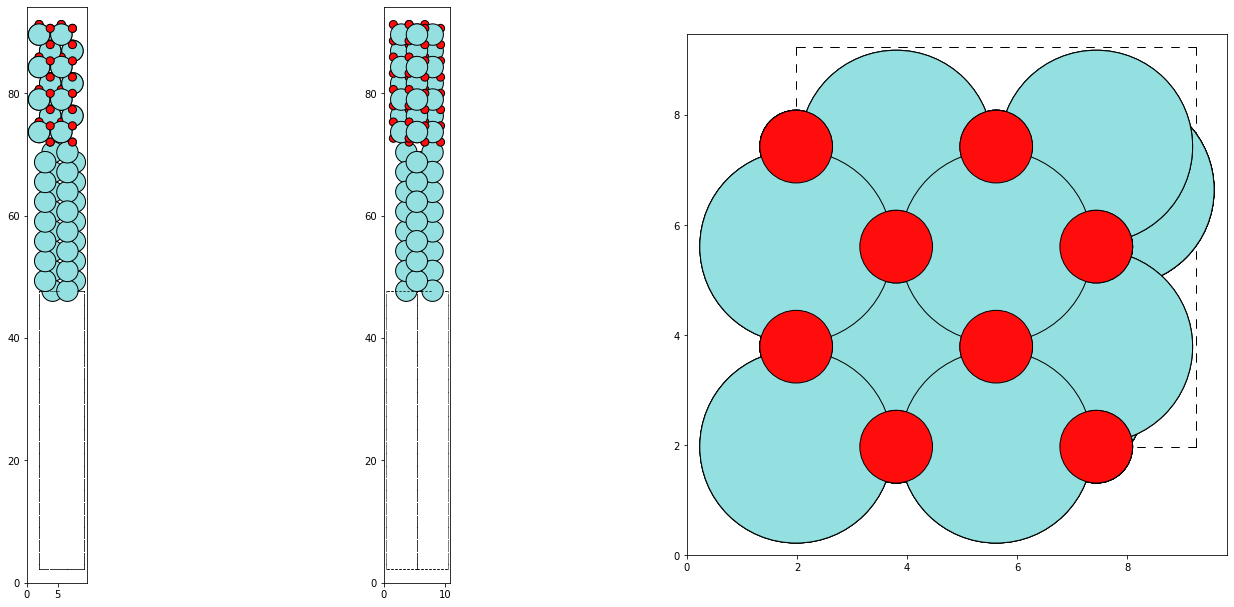

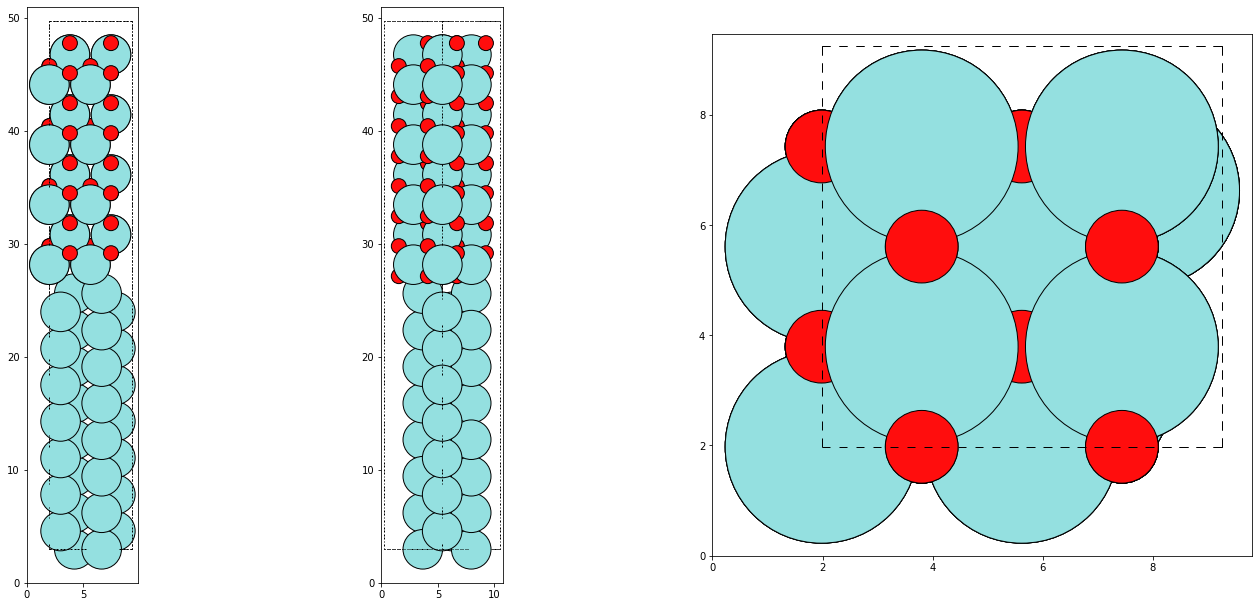

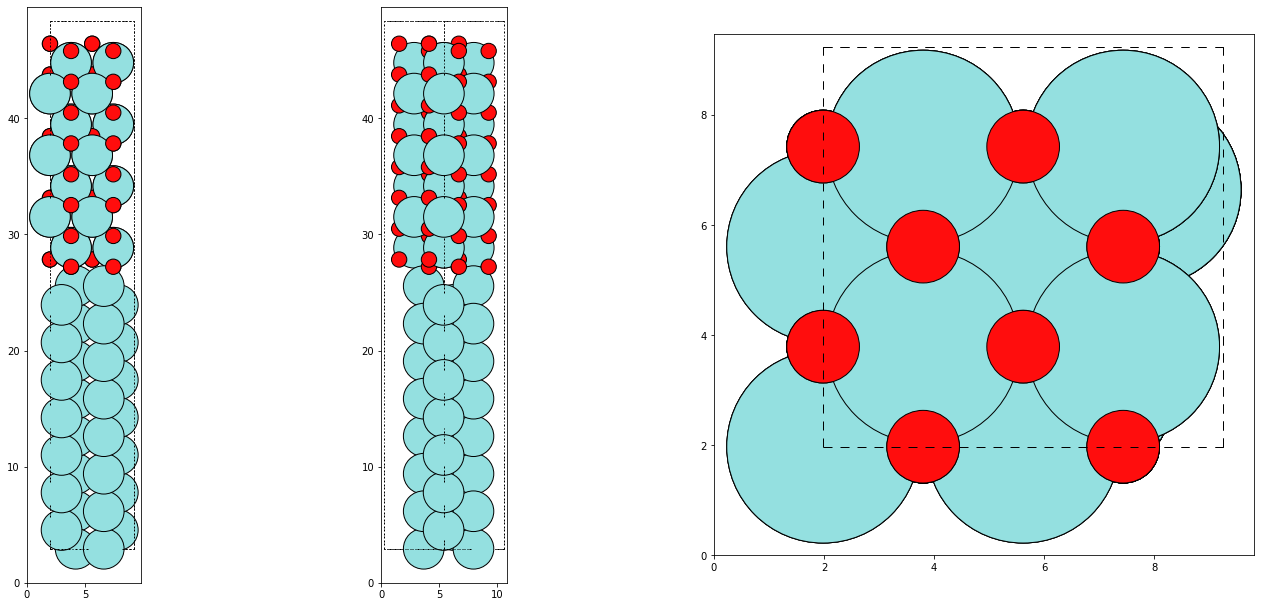

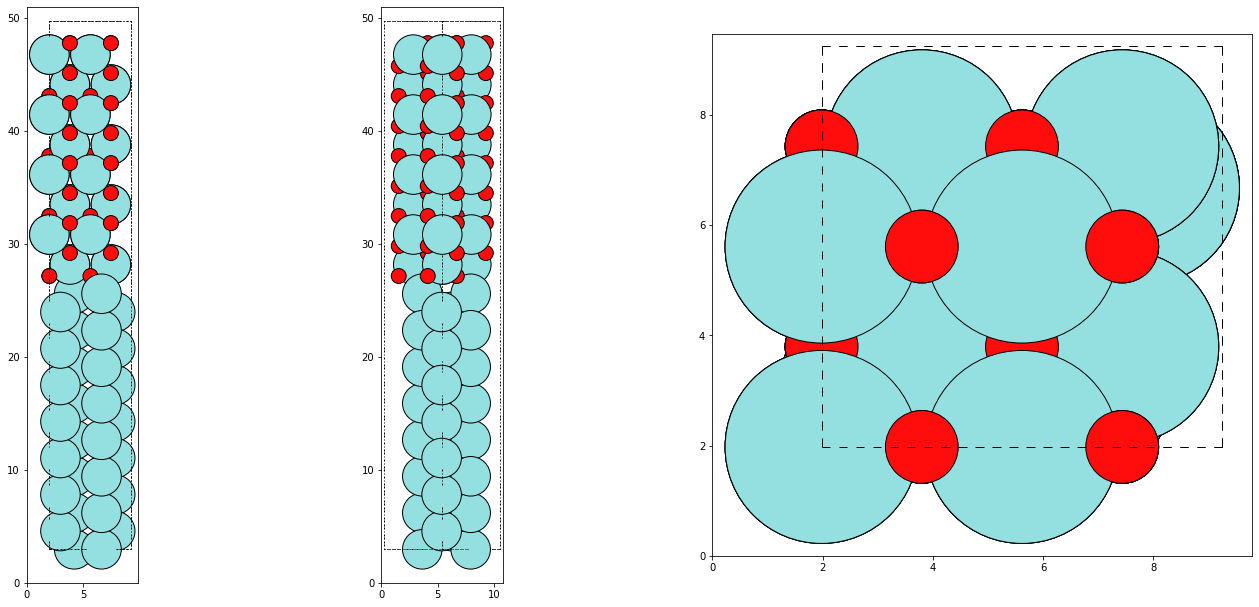

In [170]:
[plotviews(intf) for intf in intfLayer]

In [142]:
intfLayer1120 = [stack(Zr1120.copy(), I.copy(), cell=I.cell.copy(), axis=2, distance=3, maxstrain=4, reorder=True) for I in ZrO2001_2x2]
saveintfs = [a.write( f'intf_zr1120_zro2_{i}.vasp', format='vasp',sort=True,  direct=True,  wrap=True) for i, a in enumerate(intfLayer1120)]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 273
         Function evaluations: 435
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 291
         Function evaluations: 467
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 276
         Function evaluations: 448
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 301
         Function evaluations: 475


[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

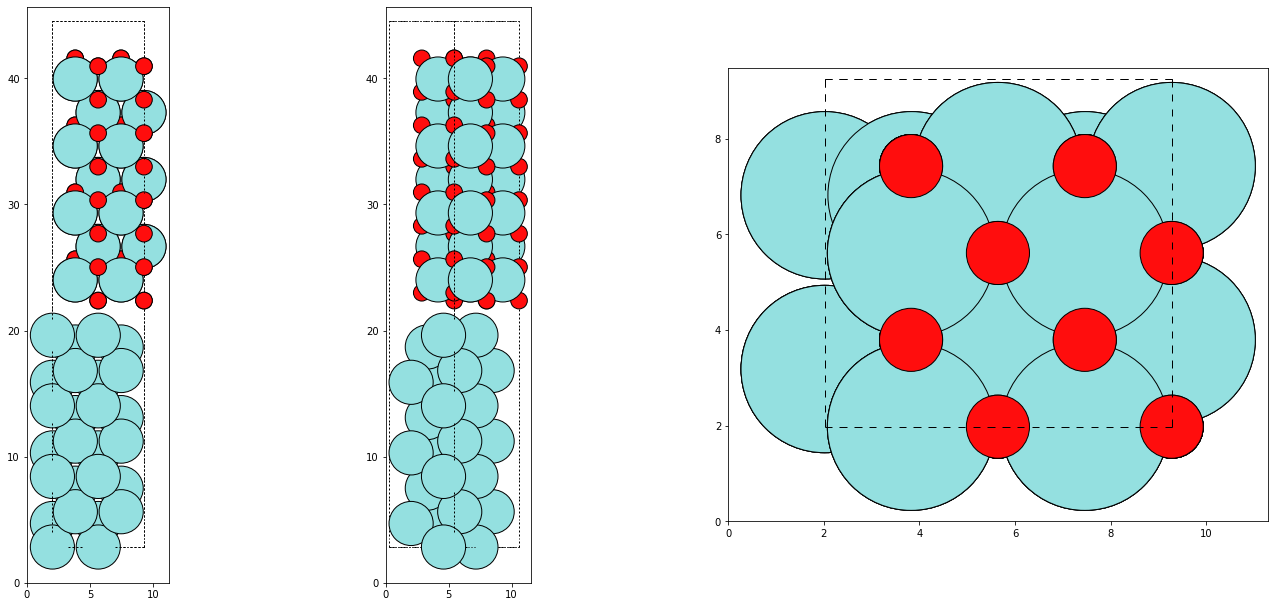

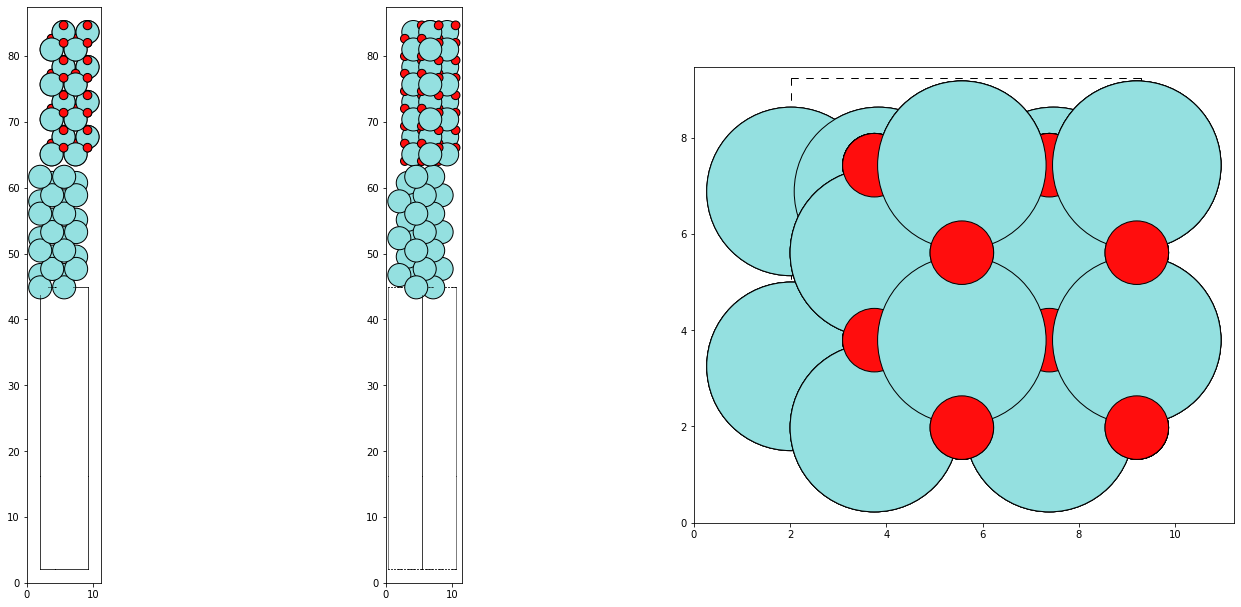

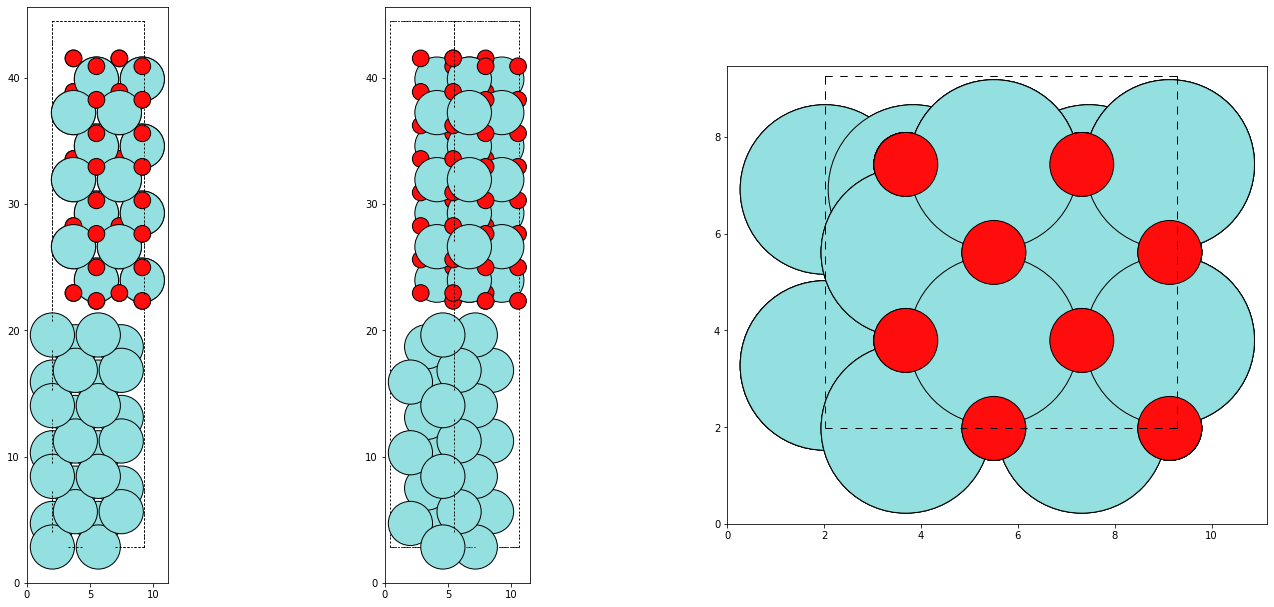

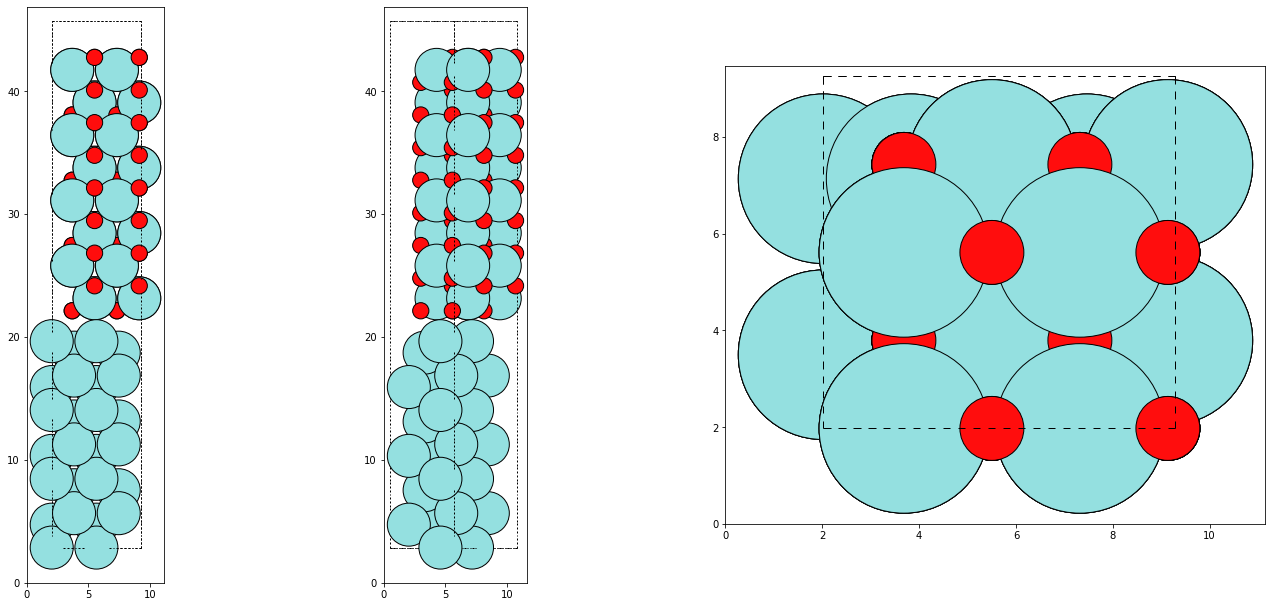

In [143]:
[plotviews(intf) for intf in intfLayer1120]

In [29]:
ZrO2001Oterm[0]

Atoms(symbols='O4ZrO4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 50.22092905883963])

In [ ]:
write('Interfaces/Layer_ZrO2.vasp', LayerZrO2)

In [ ]:
write('Interfaces/Layer_Zr1010.vasp', LayerZr1010)

Treated in vesta, can see a small probable coincidence at 2x4:
![coincidence]('Interfaces/Layer_Zr1010_coincidence.tiff')

In [ ]:
Interface = stack(Zr1010, oterm_zro2111x2,maxstrain=2, distance=2 )

In [ ]:
ax1, ax2,ax3 = plotviews(Interface)

In [ ]:
Interface.get_global_number_of_atoms()

In [ ]:
1/np.sqrt(26)

In [ ]:
5/np.sqrt(26)

# Stack

In [ ]:
STACKED = stack(oterm_zro2111x2, ZrHCP1010,maxstrain=1.0, distance=5.0)

In [ ]:
view(STACKED)

In [ ]:
STACKED.__dict__.keys()

In [ ]:
STACKED.__dict__['_cellobj']

In [ ]:
STACKED.cell

In [ ]:
ZrO2_super.cell

In [ ]:
ZrHCP1010.cell

In [ ]:
STACKED.get_global_number_of_atoms()

In [ ]:
view(ZrHCP1010)

In [ ]:
Zr.cell